# Interaction between mock, CV, and novel taxa results
The purpose of this notebook is to plot the F-measure (or other metric) scores achieved for mock community, cross-validated, and novel taxa evaluations with each method/parameter configuration. Each configuration that is tested in all three evaluations will be plotted in 3D space as a single point (averaged across all datasets/samples, e.g., all samples in each mock community will be averaged since the same samples do not exist in the cv and nt evals).

First we load modules and data.

In [1]:
from os.path import join, expandvars
import pandas as pd
import matplotlib.pyplot as plt
import seaborn.xkcd_rgb as colors


In [2]:
project_dir = expandvars("../../")
precomputed_results = join(project_dir, "data", "precomputed-results")
mock_results = pd.DataFrame.from_csv(join(
    precomputed_results, "mock-community", "mock_results.tsv"), sep="\t")
cv_results = pd.DataFrame.from_csv(join(
    precomputed_results, "cross-validated", "evaluate_classification_summary.csv"))
nt_results = pd.DataFrame.from_csv(join(
    precomputed_results, "novel-taxa-simulations", "evaluate_classification_summary.csv"))



We can set some global variables here

In [3]:
level = 6
metric = "F-measure"
method = "Method"
params = "Parameters"
reference = "Reference"
dataset = "Dataset"

color_palette={
    'expected': 'black', 'rdp': colors['baby shit green'], 'sortmerna': colors['macaroni and cheese'],
    'uclust': 'coral', 'blast': 'indigo', 'blast+': colors['electric purple'], 'naive-bayes': 'dodgerblue',
    'naive-bayes-bespoke': 'blue', 'vsearch': 'firebrick'
}



We will use the following functions for combining evaluations and plotting

In [89]:
def combined_evaluation(mock_results, cv_results, nt_results, params, metric, method, reference, dataset, domain, level):
    pd.options.mode.chained_assignment = None  # default='warn'

    # Filter mock results to use correct datasets
    dataset_ids = ['mock-1', 'mock-2', 'mock-3', 'mock-4', 'mock-5', 'mock-7', 'mock-8', 'mock-9',
                   'mock-10', 'mock-12', 'mock-16', 'mock-18', 'mock-19', 'mock-20', 'mock-21', 
                   'mock-22', 'mock-23', 'mock-24', 'mock-26-ITS1', 'mock-26-ITS9']
    method_ids = ['rdp', 'sortmerna', 'uclust', 'blast', 'blast+', 'naive-bayes', 'naive-bayes-bespoke', 'vsearch']
    if domain == "fungi":
        ref_ids = ['F1-REF', 'F2-REF', 'F3-REF', 'unite_20.11.2016_clean_fullITS']
    elif domain == "bacteria":
        ref_ids = ['B1-REF', 'B2-REF', 'B3-REF', 'gg_13_8_otus']
    # otherwise combine bacteria and fungi
    else:
        ref_ids = ['B1-REF', 'B2-REF', 'B3-REF', 'gg_13_8_otus', 'F1-REF', 'F2-REF', 'F3-REF', 'unite_20.11.2016_clean_fullITS']

    # Set level
    mock_results = mock_results[mock_results['Level'] == level]
    nt_results = nt_results[nt_results['level'] == level]
    
    # Filter mock results to use correct datasets
    mock_results = mock_results[(mock_results[reference].isin(ref_ids)) & 
                                (mock_results[method].isin(method_ids)) &
                                (mock_results[dataset].isin(dataset_ids))]

    # Filter nt and cv results to use correct datasets
    cv_results = cv_results[cv_results[dataset].isin(ref_ids)]
    nt_results = nt_results[nt_results[dataset].isin(ref_ids)]

    # modify parameter names so all evaluations use same conventions
    mock_results[params] = mock_results[params].str.replace('char:8192:','')

    # extract per-level results from cv_results
    for m in ['Precision', 'Recall', 'F-measure']:
        level_results = []
        for v in cv_results[m]:
            v = v.strip('[]').split(', ')
            level_results.append(float(v[level]))
        cv_results[m] = level_results

    # join all eval dataframes into one
    mock_mean = mock_results.groupby([method, params]).mean()
    cv_mean = cv_results.groupby([method, params]).mean()
    nt_mean = nt_results.groupby([method, params]).mean()
    evals_combined  = pd.concat([mock_mean[metric], cv_mean[metric], nt_mean[metric]], axis=1, join='inner')
    evals_combined.columns = ['Mock', 'Cross-validated', 'Novel taxa']
    
    return evals_combined


def plot_3d(evals_combined):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.set_facecolor('white')
    for m in evals_combined.index.levels[0]:
        evals_subset = evals_combined.loc[m]
        ax.scatter(xs=evals_subset['Mock'],
                   ys=evals_subset['Cross-validated'],
                   zs=evals_subset['Novel taxa'],
                   c=color_palette[m])

    ax.set_xlabel('Mock')
    ax.set_ylabel('Cross-validated')
    ax.set_zlabel('Novel taxa')

    plt.show()
    
    return ax


## Bacteria level 6

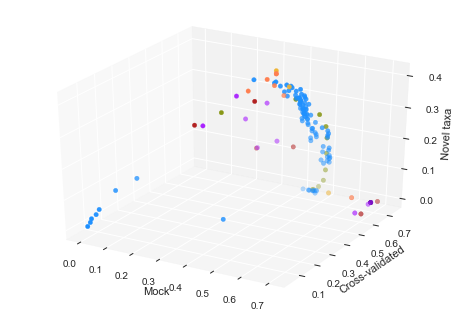

In [90]:
evals_bacteria = combined_evaluation(
    mock_results, cv_results, nt_results, params,
    metric, method, reference, dataset, "bacteria", level)

ax = plot_3d(evals_bacteria)

#ax.get_figure().savefig(facecolor="white")

In [33]:
# find top-performing methods across all evals
evals_bacteria['sum'] = evals_bacteria['Mock'] + evals_bacteria['Cross-validated'] + evals_bacteria['Novel taxa']
evals_bacteria.sort_values('sum', ascending=False)[:10]

Mock  Cross-validated  Novel taxa  \
Method      Parameters                                                  
rdp         0.8                 0.492848         0.687848    0.263614   
naive-bayes 0.001:[6,6]:0.9     0.415407         0.696272    0.330219   
            0.001:[8,8]:0.94    0.426216         0.704515    0.309133   
            0.001:[7,7]:0.9     0.424880         0.709273    0.302739   
            0.001:[8,8]:0.92    0.428490         0.710509    0.297134   
rdp         0.7                 0.510633         0.701097    0.224095   
naive-bayes 0.001:[8,8]:0.9     0.435968         0.717580    0.279890   
            0.001:[32,32]:0.96  0.507587         0.720555    0.204027   
            0.001:[7,7]:0.92    0.416351         0.702054    0.313152   
            0.001:[32,32]:0.94  0.509804         0.722860    0.194777   

                                     sum  
Method      Parameters                    
rdp         0.8                 1.444310  
naive-bayes 0.001:[6,6]:0.9     1.441898  
            0.001:[8,8]:0.94    1.439865  
            0.001:[7,7]:0.9     1.436892  
            0.001:[8,8]:0.92    1.436133  
rdp         0.7                 1.435825  
naive-bayes 0.001:[8,8]:0.9     1.433438  
            0.001:[32,32]:0.96  1.432170  
            0.001:[7,7]:0.92    1.431557  
            0.001:[32,32]:0.94  1.427441

## Fungi level 6

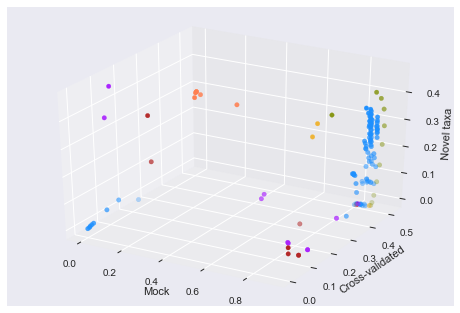

In [29]:
evals_fungi = combined_evaluation(
    mock_results, cv_results, nt_results, params,
    metric, method, reference, dataset, "fungi", level)

ax = plot_3d(evals_fungi)

ax.get_figure().savefig(join())

In [34]:
# find top-performing methods across all evals
evals_fungi['sum'] = evals_fungi['Mock'] + evals_fungi['Cross-validated'] + evals_fungi['Novel taxa']
evals_fungi.sort_values('sum', ascending=False)[:10]

Mock  Cross-validated  Novel taxa  \
Method      Parameters                                                  
rdp         0.9                 0.906355         0.473657    0.424299   
            0.8                 0.905680         0.501124    0.390912   
            0.7                 0.907486         0.517010    0.345585   
            0.6                 0.910070         0.520174    0.283196   
naive-bayes 0.001:[8,8]:0.96    0.884903         0.510246    0.316237   
            0.001:[7,7]:0.98    0.860708         0.498882    0.346082   
            0.001:[8,8]:0.98    0.859139         0.504425    0.337267   
            0.001:[11,11]:0.98  0.886041         0.509096    0.303879   
            0.001:[6,6]:0.98    0.860104         0.476872    0.359483   
            0.001:[8,8]:0.94    0.884561         0.509881    0.296153   

                                     sum  
Method      Parameters                    
rdp         0.9                 1.804311  
            0.8                 1.797716  
            0.7                 1.770081  
            0.6                 1.713441  
naive-bayes 0.001:[8,8]:0.96    1.711387  
            0.001:[7,7]:0.98    1.705671  
            0.001:[8,8]:0.98    1.700832  
            0.001:[11,11]:0.98  1.699015  
            0.001:[6,6]:0.98    1.696459  
            0.001:[8,8]:0.94    1.690595

## Bacteria and fungi level 6

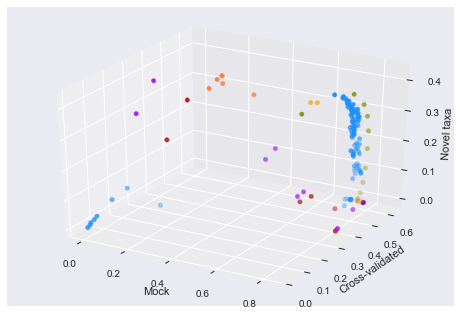

In [36]:
evals_combined = combined_evaluation(
    mock_results, cv_results, nt_results, params,
    metric, method, reference, dataset, None, level)

ax = plot_3d(evals_combined)

ax.get_figure().savefig(join())

In [37]:
# find top-performing methods across all evals
evals_combined['sum'] = evals_combined['Mock'] + evals_combined['Cross-validated'] + evals_combined['Novel taxa']
evals_combined.sort_values('sum', ascending=False)[:10]


Mock  Cross-validated  Novel taxa  \
Method      Parameters                                                  
rdp         0.8                 0.772814         0.594486    0.327263   
            0.9                 0.751387         0.561339    0.368529   
            0.7                 0.779763         0.609053    0.284840   
naive-bayes 0.001:[8,8]:0.94    0.737048         0.607198    0.302643   
            0.001:[8,8]:0.96    0.720296         0.602130    0.318201   
            0.001:[8,8]:0.92    0.737779         0.609112    0.290106   
            0.001:[11,11]:0.98  0.729064         0.604925    0.300725   
rdp         0.6                 0.780555         0.618388    0.232588   
naive-bayes 0.001:[7,7]:0.96    0.707514         0.593893    0.329782   
            0.001:[8,8]:0.9     0.740186         0.614533    0.274950   

                                     sum  
Method      Parameters                    
rdp         0.8                 1.694564  
            0.9                 1.681255  
            0.7                 1.673657  
naive-bayes 0.001:[8,8]:0.94    1.646889  
            0.001:[8,8]:0.96    1.640628  
            0.001:[8,8]:0.92    1.636997  
            0.001:[11,11]:0.98  1.634714  
rdp         0.6                 1.631531  
naive-bayes 0.001:[7,7]:0.96    1.631189  
            0.001:[8,8]:0.9     1.629668

## Results from levels 2 through 6

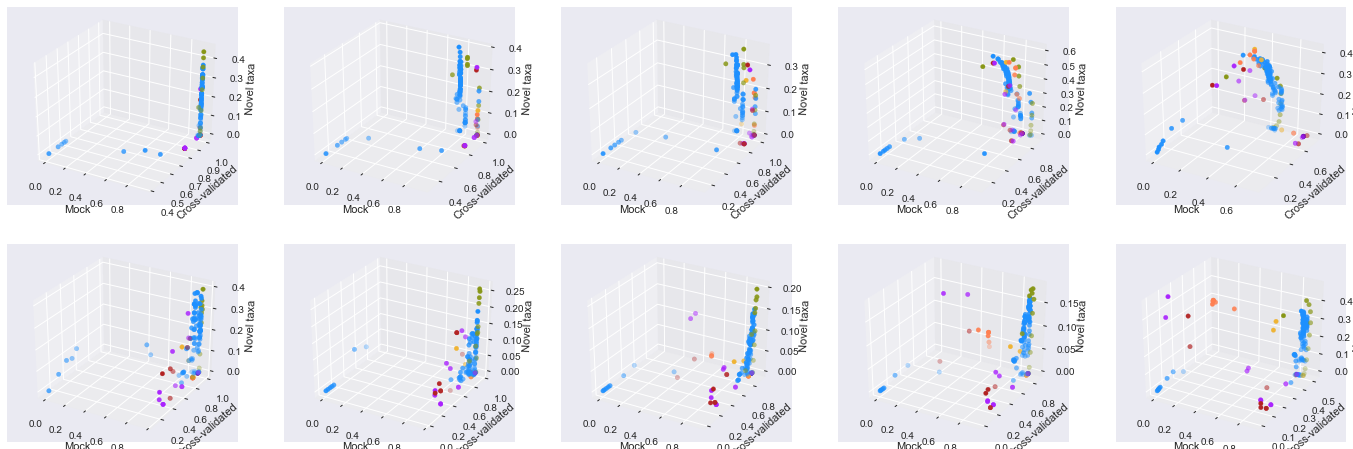

In [78]:
p = plt.figure(figsize=(24, 8))
c = 0
for d in ["bacteria", "fungi"]:
    if d == "fungi":
        c = 5
    for l in range(2,7):
        evals_combined = combined_evaluation(
        mock_results, cv_results, nt_results, params,
        metric, method, reference, dataset, d, l)

        #p = plt.subplot(5, 2, l-1)
        #ax = p.gca(projection='3d')
        ax = p.add_subplot(2, 5, l-1+c, projection='3d')
        for m in evals_combined.index.levels[0]:
            evals_subset = evals_combined.loc[m]
            ax.scatter(xs=evals_subset['Mock'],
                       ys=evals_subset['Cross-validated'],
                       zs=evals_subset['Novel taxa'],
                       c=color_palette[m])

        ax.set_xlabel('Mock')
        ax.set_ylabel('Cross-validated')
        ax.set_zlabel('Novel taxa')

plt.show()
